# 1. Install Dependencies and Setup

In [3]:
!pip install tensorflow opencv-python matplotlib

  Using cached tensorflow-2.17.0-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/385.0 MB 5.7 MB/s eta 0:01:08
   ---------------------------------------- 0.6/385.0 MB 6.4 MB/s eta 0:01:00
   ---------------------------------------- 0.7/385.0 MB 6.7 MB/s eta 0:00:58
   ---------------------------------------- 1.3/385.0 MB 6.8 MB/s eta 0:00:57
   ---------------------------------------- 2.2/385.0 MB 9.2 MB/s eta 0:00:42
   ---------------------------------------- 2.7/385.0 MB 9.6 MB/s eta 0:00:41
   ---------------------------------------- 2.9/385.0 MB 9.3 MB/s eta 0:00:42
   ---------------------------------------- 3.6/385.0 MB 9.6 MB/s eta 0:00:40
   ---------

In [1]:
!pip list

Package                           Version
--------------------------------- ------------
absl-py                           2.1.0
aiobotocore                       2.7.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.0
anaconda-project                  0.11.1
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy                           5.3.4
asttokens                         2.0.5
astunparse               

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr

C:\Users\User\AppData\Local\Temp\ipykernel_9148\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
data_dir = 'data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

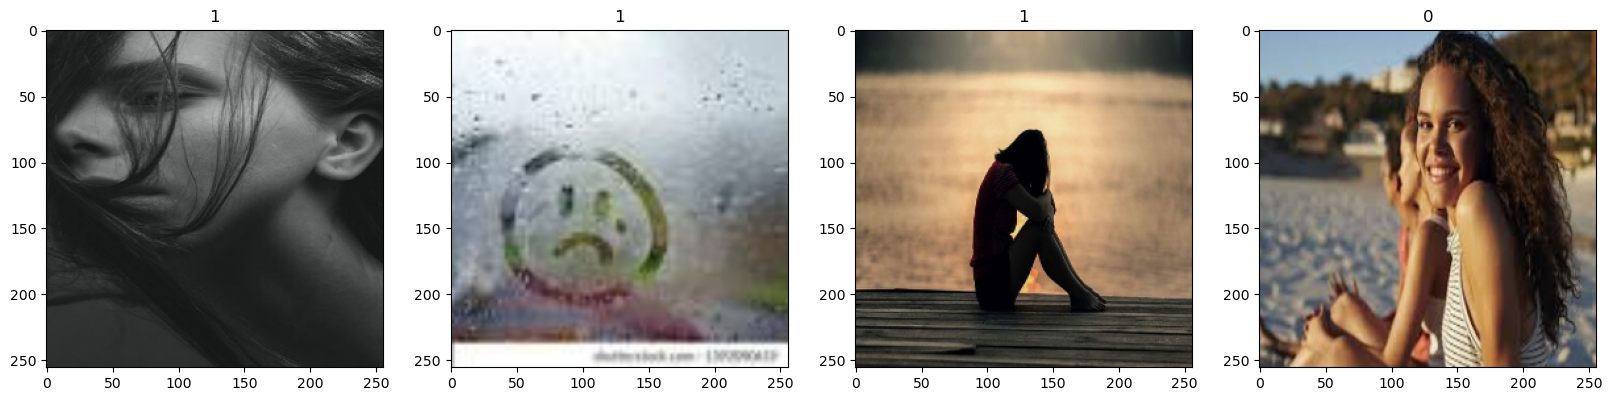

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
data.as_numpy_iterator().next()

(array([[[[0.43137255, 0.4117647 , 0.3254902 ],
          [0.43529412, 0.41568628, 0.32941177],
          [0.43529412, 0.41568628, 0.3372549 ],
          ...,
          [0.45294118, 0.4336742 , 0.34637713],
          [0.4392157 , 0.43137255, 0.33333334],
          [0.44117647, 0.43333334, 0.33529413]],
 
         [[0.43137255, 0.4117647 , 0.33333334],
          [0.43529412, 0.41568628, 0.3372549 ],
          [0.43529412, 0.41568628, 0.3372549 ],
          ...,
          [0.45294118, 0.43333334, 0.3509804 ],
          [0.4509804 , 0.43529412, 0.3372549 ],
          [0.44995788, 0.4342716 , 0.3362324 ]],
 
         [[0.43137255, 0.4117647 , 0.33333334],
          [0.43529412, 0.41568628, 0.3372549 ],
          [0.43529412, 0.41568628, 0.3372549 ],
          ...,
          [0.45294118, 0.4372549 , 0.33818933],
          [0.45319778, 0.4375115 , 0.33947226],
          [0.4490196 , 0.43333334, 0.33529413]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

# 5. Split Data

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [17]:
train_size

7

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [19]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\User\anaconda3\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.5190 - loss: 0.9290 - val_accuracy: 0.7656 - val_loss: 0.6784
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 0.7542 - loss: 0.6748 - val_accuracy: 0.6094 - val_loss: 0.6214
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - accuracy: 0.6781 - loss: 0.5996 - val_accuracy: 0.7656 - val_loss: 0.4693
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.7020 - loss: 0.5318 - val_accuracy: 0.8594 - val_loss: 0.3736
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.8395 - loss: 0.4006 - val_accuracy: 0.7500 - val_loss: 0.4279
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - accuracy: 0.8834 - loss: 0.4020 - val_accuracy: 0.9375 - val_loss: 0.3327
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step - accuracy: 0.8587 - loss: 0.3385 - val_accuracy: 0.9062 - val_loss: 0.2312
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 452ms/step - accuracy: 0.9163 - loss: 0.2055 - val_accuracy: 0.9688 - val_loss:

# 8. Plot Performance

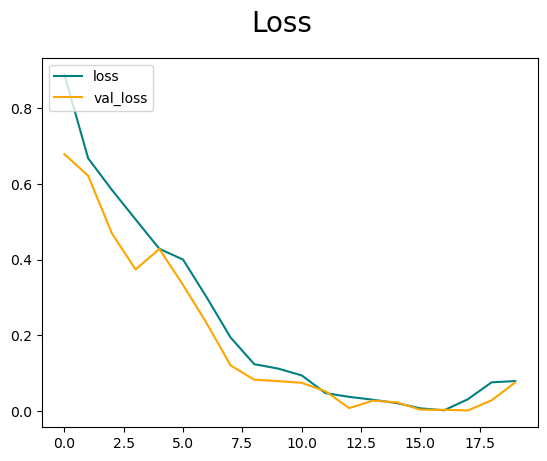

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

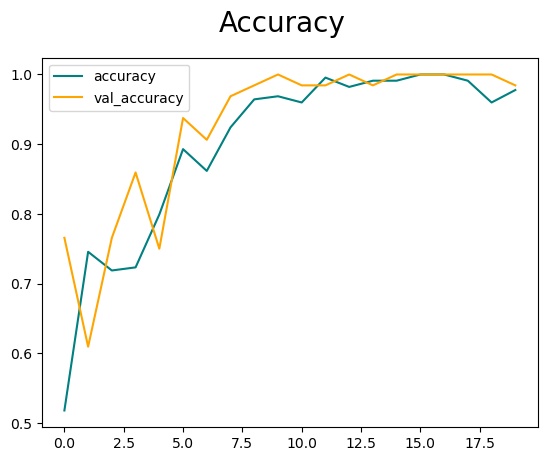

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

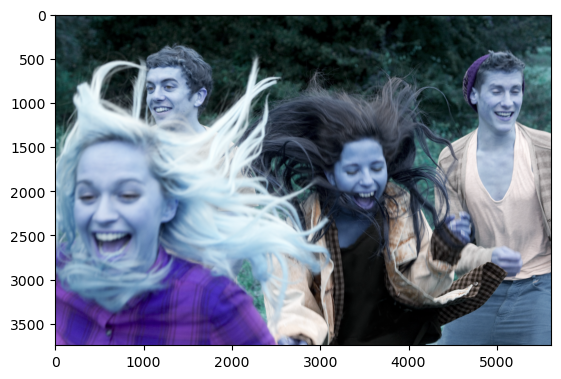

In [36]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

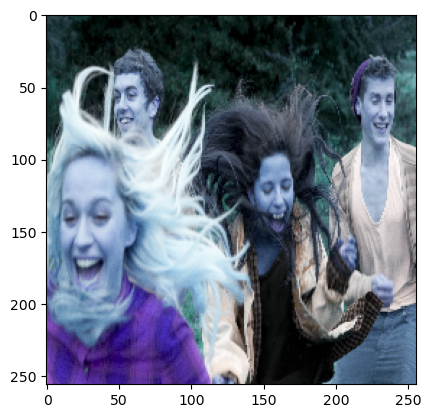

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


In [39]:
yhat

array([[0.00218181]], dtype=float32)

In [40]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


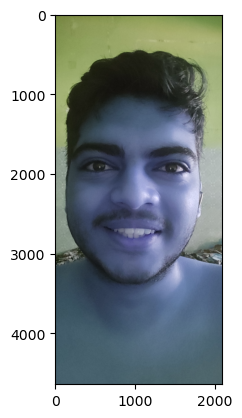

In [45]:
img1 = cv2.imread('IMG_20240828_070213.jpg')
plt.imshow(img1)
plt.show()

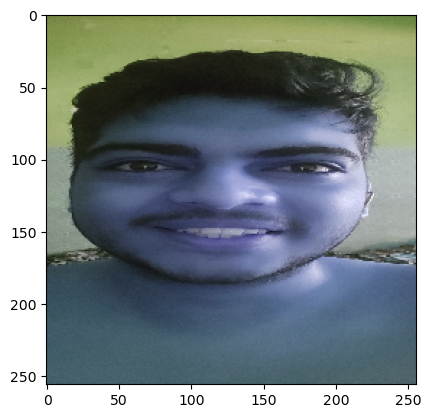

In [46]:
resize1 = tf.image.resize(img1, (256,256))
plt.imshow(resize1.numpy().astype(int))
plt.show()

In [47]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [48]:
yhat

array([[0.00218181]], dtype=float32)

In [49]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('models','imageclassifier.h5'))

In [43]:
new_model = load_model('imageclassifier.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'imageclassifier.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))